In [67]:
%env JAX_ENABLE_X64=1


env: JAX_ENABLE_X64=1


In [68]:
import jax
import jax.numpy as jnp
from jax import grad, jit
import numpy as np
import tqdm
import matplotlib.pyplot as plt


In [69]:
def mse(y_hat, y):
  return ((y_hat - y)**2).mean() 

@jit
def cost_function(X, w, b, y):
    """Cost function for a linear regression. A forward pass of our model.

    Args:
        X: a features matrix.
        w: weights (a column vector).
        b: a bias.
        y: a target vector.

    Returns:
        scalar: a cost of this solution.    
    """
    y_hat = X.dot(w) + b # Predict values.
    return mse(y_hat, y)# Return cost.

In [70]:

def prepare_data(key, x_dims=10, N=100, x_domain=(-10, 10), noise_model=(0, 1), truth=None):
  key_x, key_w, key_noise = jax.random.split(key, 3)
  if truth is None:
    W_truth = jax.random.normal(key_w, (x_dims, 1))
    b_truth = jax.random.normal(key_w, (1,))
  else:
    W_truth, b_truth = truth
  
  mu, sigma = noise_model
  X = jax.random.uniform(key_x, (N, x_dims), minval=x_domain[0], maxval=x_domain[1]) 

  y = X @ W_truth + b_truth
  noise = np.random.normal(mu, sigma, size=(N, x_dims))

  X += noise
  print(X.shape, y.shape)
  plt.scatter(X[:, 0].flatten(), y)
  x_truth = np.concatenate( [
                       np.ones((1, x_dims)) * x_domain[0], 
                       np.ones((1, x_dims)) * x_domain[1],  
                       ])
  y_truth = x_truth @ W_truth + b_truth
  plt.plot(x_truth[:, 0], y_truth)
  return X, y, W_truth, b_truth, noise
 

In [71]:
def train(X, y, W, b, lr=0.001, epochs=200):
  losses = []
  xs = []
  ys = []
  for i in tqdm.tqdm(range(epochs)):
      loss, (W_grad, b_grad) = jax.value_and_grad(cost_function, (1, 2))(X, W, b, y)
      W -= lr * W_grad
      b -= lr * b_grad
      if i % 1 == 0:
          losses.append(loss)
          xs.append((W[0]))
          ys.append((b))
  return losses, W, b, xs, ys

def train_mnist(X, y, W, b, X_test, y_test, lr=0.001, epochs=200):
  losses = []
  accs = []
  xs = []
  ys = []
  for i in tqdm.tqdm(range(epochs)):
      loss, (W_grad, b_grad) = jax.value_and_grad(cost_function, (1, 2))(X, W, b, y)
      acc = accuracy(W, b, X_test, y_test,)
    
      W -= lr * W_grad
      b -= lr * b_grad
      if i % 1 == 0:
          losses.append(loss)
          accs.append(acc)
          xs.append((W[0]))
          ys.append((b))
  return losses, accs, W, b, xs, ys


In [72]:
def get_analytical_solution(X, y):
  X_b = np.append(X, np.ones((X.shape[0], 1)), axis=1)
  print((X_b.T @ X_b).shape )
  analytical_solution = np.linalg.pinv(X_b.T @ X_b) @ X_b.T @ y
  hessian = X_b.T @ X_b
  W = analytical_solution[:-1]
  b = analytical_solution[-1] 
  return W, b, hessian

In [73]:
from matplotlib.animation import FuncAnimation

def train_incremental(X_1, y_1, X_2, y_2, W, b, sample=0.1, lr=0.001, epochs=200, X_m=None, y_m=None):
  if X_m is not None and y_m is not None:
    X = X_m
    y = y_m
  else:
    idx = np.random.choice(np.arange(len(X_1)), int(len(X_1)* sample))
    X = jnp.concatenate([X_1[idx], X_2])
    y = jnp.concatenate([y_1[idx], y_2])
    p = np.random.permutation(len(X))
    X = X[p]
    y = y[p]
  global_losses = []
  local_losses = []
  total_losses = []

  xs = []
  ys = []
  for i in tqdm.tqdm(range(epochs)):
      loss, (W_grad, b_grad) = jax.value_and_grad(cost_function, (1, 2))(X, W, b, y)
      if i % 1 == 0:
        global_loss = cost_function(X_1, W, b, y_1)
        local_loss = cost_function(X_2, W, b, y_2)
        global_losses.append(global_loss)
        local_losses.append(local_loss)
        total_losses.append(loss)
        xs.append((W[0]))
        ys.append((b))
      W -= lr * W_grad
      b -= lr * b_grad

  return global_losses, local_losses, total_losses, W, b, xs, ys



def train_incremental_mnist(X_1, y_1, X_2, y_2, W, b, X_test1, y_test1, X_test2, y_test2, X_test, y_test, sample=0.1, lr=0.001, epochs=200, X_m=None, y_m=None):
  if X_m is not None and y_m is not None:
    X = X_m
    y = y_m
  else:
    idx = np.random.choice(np.arange(len(X_1)), int(len(X_1)* sample))
    X = jnp.concatenate([X_1[idx], X_2])
    y = jnp.concatenate([y_1[idx], y_2])
    p = np.random.permutation(len(X))
    X = X[p]
    y = y[p]
  global_losses = []
  local_losses = []
  total_losses = []

  xs = []
  ys = []
  for i in tqdm.tqdm(range(epochs)):
      loss, (W_grad, b_grad) = jax.value_and_grad(cost_function, (1, 2))(X, W, b, y)
      if i % 1 == 0:
        global_loss = cost_function(X_1, W, b, y_1)
        local_loss = cost_function(X_2, W, b, y_2)
        global_losses.append((global_loss, accuracy(W, b, X_test1, y_test1)))
        local_losses.append((local_loss, accuracy(W, b, X_test2, y_test2)))
        total_losses.append((loss, accuracy(W, b, X_test, y_test)))
        xs.append((W[0]))
        ys.append((b))
      W -= lr * W_grad
      b -= lr * b_grad

  return global_losses, local_losses, total_losses, W, b, xs, ys

def train_incremental_mnist_relay(X_1, y_1, X_2, y_2, W, b, X_test1, y_test1, X_test2, y_test2, X_test, y_test, sample=0.1, lr=0.001, epochs=200, X_m=None, y_m=None):
  if X_m is not None and y_m is not None:
    X = X_m
    y = y_m
  else:
    idx = np.random.choice(np.arange(len(X_1)), int(len(X_1)* sample))
    X = jnp.concatenate([X_1[idx], X_2])
    y = jnp.concatenate([y_1[idx], y_2])
    p = np.random.permutation(len(X))
    X = X[p]
    y = y[p]
  global_losses = []
  local_losses = []
  total_losses = []

  relay_g = []
  relay_l = []

  xs = []
  ys = []
  for i in tqdm.tqdm(range(epochs)):
      loss, (W_grad, b_grad) = jax.value_and_grad(cost_function, (1, 2))(X, W, b, y)
      rg = rayleigh_quotient(cost_function_global, pack_params(W, b), pack_params(W_grad, b_grad))
      rl = rayleigh_quotient(cost_function_local, pack_params(W, b), pack_params(W_grad, b_grad))
      if i % 1 == 0:
        global_loss = cost_function(X_1, W, b, y_1)
        local_loss = cost_function(X_2, W, b, y_2)
        global_losses.append((global_loss, accuracy(W, b, X_test1, y_test1)))
        local_losses.append((local_loss, accuracy(W, b, X_test2, y_test2)))
        total_losses.append((loss, accuracy(W, b, X_test, y_test)))
        xs.append((W[0]))
        ys.append((b))
        relay_g.append(rg)
        relay_l.append(rl)
      W -= lr * W_grad
      b -= lr * b_grad

  return global_losses, local_losses, total_losses, W, b, xs, ys, relay_g, relay_l




# The 1-D case

(500, 1) (500, 1)


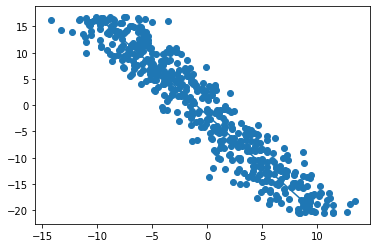

In [74]:
# Initial data
x_dims = 1

key1 = jax.random.PRNGKey(2541)
X_1, y_1, W_t, b_t, _ = prepare_data(key1, N=500, x_dims=x_dims, x_domain=[-10, 10], noise_model=[0, 2])

(50, 1) (50, 1)


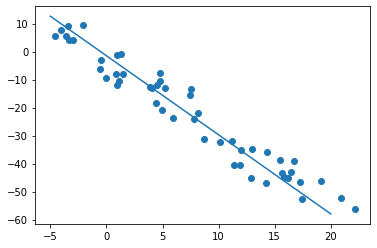

In [75]:
key2 = jax.random.PRNGKey(666)
X_2, y_2, _, _, _ = prepare_data(key2, x_domain=(-5, 20), noise_model=[0, 2], 
                                 x_dims=x_dims, N=50, truth=(W_t * 1.5, b_t * 0.8))


In [76]:
from jax import vmap

idx = np.random.choice(np.arange(len(X_1)), int(len(X_1) * 0.01))
X_s = np.concatenate([X_1[idx], X_2])
y_s = np.concatenate([y_1[idx], y_2])

W_a, b_a, h_a = get_analytical_solution(X_1, y_1)
W_a_l, b_a_l, h_a_l = get_analytical_solution(X_2, y_2)
W_a_i, b_a_i, h_a_i = get_analytical_solution(X_s, y_s)

print("Orignal optimal", W_a, b_a)
print("Local optimal", W_a_l, b_a_l)
print("New optimal", W_a_i, b_a_i)
def get_eigen(h):
    eigens = np.linalg.eig(h)[0]
    #eigens /= max(eigens)
    #eigens = ["{:.2f}".format(float(i)) for i in eigens]
    return eigens#" ".join(eigens)
we, be = get_eigen(h_a_l)
we, be, we/be

(2, 2)
(2, 2)
(2, 2)
Orignal optimal [[-1.74283084]] [-1.43587982]
Local optimal [[-2.50926869]] [-3.61310281]
New optimal [[-2.4307428]] [-4.12556238]


(5457.581406234657, 25.018449597436014, 218.1422707662097)

Text(0, 0.5, 'y')

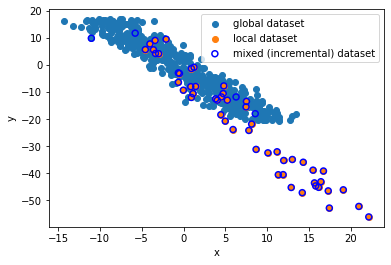

In [77]:
import matplotlib
plt.scatter(X_1, y_1, label="global dataset")
plt.scatter(X_2, y_2, label="local dataset")
plt.scatter(X_s, y_s, label="mixed (incremental) dataset", marker= matplotlib.markers.MarkerStyle('o', 'none'), color='b')
plt.legend()
plt.xlabel("x")
plt.ylabel("y")

100%|██████████| 100/100 [00:00<00:00, 386.01it/s]


Initial loss: 286.48602467977184, final loss 13.76489541465558
[[-1.73095577]] -0.24028658822421958


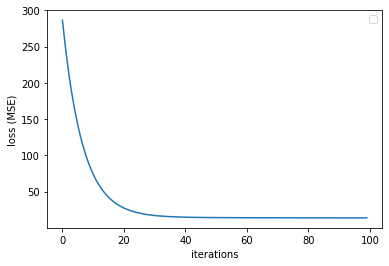

In [78]:
# params
W = jnp.ones((x_dims, 1))
b = 0.

loss1, W_g, b_g, wg_traj, bg_traj = train(X_1, y_1, W, b, lr=0.001, epochs=100)
plt.plot(loss1)
plt.xlabel("iterations")
plt.ylabel("loss (MSE)")
plt.legend()
print("Initial loss: {}, final loss {}".format(loss1[0], loss1[-1]))
print(W_g, b_g)

In [79]:
%matplotlib inline
def plot_contour(X, y, wtraj=None, btraj=None, wmin = -5, wmax = 2, bmin = -8, bmax = 2, steps = 1000,):
  points = np.linspace(0, 1, steps)
  wspace_o = points * (wmax - wmin) + wmin
  bspace_o = points * (bmax - bmin) + bmin
  wspace, bspace = np.meshgrid(wspace_o, bspace_o, indexing='ij')
  z_global = mesh_cost(X, wspace_o, bspace_o, y).flatten()
  z_global = np.asarray(z_global).reshape(wspace.shape)

  W_a, b_a, _ = get_analytical_solution(X, y)
  levels = np.linspace(np.min(z_global), np.max(z_global), 30)
  print(W_a, b_a)

  figure = plt.figure()
  axes = figure.add_subplot()
  f1 = axes.contour(wspace, bspace, z_global,levels=levels)
  axes.set_xlabel("weight")
  axes.set_ylabel("bias")
  axes.set_xlim(wmin, wmax)
  axes.set_ylim(bmin, bmax)
  axes.clabel(f1, inline=True, fontsize=10)

  plt.scatter(float(W_a.flatten()), float(b_a.flatten()), color='r', label="Incremental Dataset Optimal")

  if None not in (wtraj, btraj):
    axes.plot(wg_traj, bg_traj, label="Global dataset training trajectory", color='blue')
  return figure, axes


mesh_cost = vmap(vmap(cost_function, in_axes=(None, 0, None, None), out_axes=0), in_axes=(None, None, 0, None), out_axes=1)

(2, 2)
[[-1.74283084]] [-1.43587982]


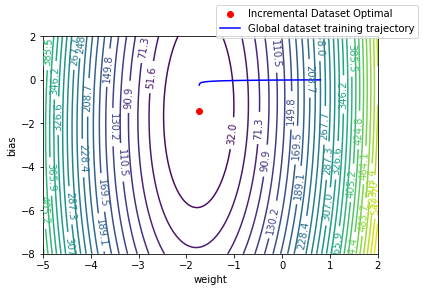

In [80]:
fig, ax = plot_contour(X_1, y_1, wg_traj, bg_traj)
fig.legend()


(2, 2)
[[-2.50926869]] [-3.61310281]


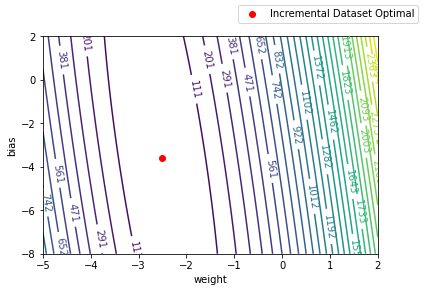

In [81]:
fig, ax = plot_contour(X_2, y_2)
fig.legend()

(2, 2)
[[-2.4307428]] [-4.12556238]


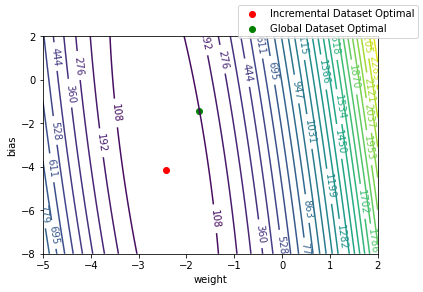

In [82]:
fig, ax = plot_contour(X_s, y_s)

ax.scatter(float(W_a), float(b_a), label="Global Dataset Optimal", color='green')
fig.legend()


100%|██████████| 200/200 [00:00<00:00, 372.61it/s]


[[-2.50878724]] -2.913278692807637
(2, 2)
[[-2.4307428]] [-4.12556238]


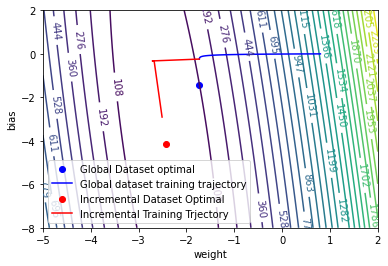

In [83]:
%matplotlib inline
gl, ll, tl, W, b, wl_traj, bl_traj = train_incremental(X_1, y_1, X_2, y_2, W_g, b_g, X_m=X_s, y_m=y_s, lr=0.005, sample=0.2, epochs=200,)
print(W, b,)
fig, axes = plot_contour(X_s, y_s, wg_traj, bg_traj)
axes.plot(wl_traj, bl_traj, color='r', label="Incremental Training Trjectory")
axes.scatter(float(W_a), float(b_a), label="Global Dataset optimal", color='blue')
handles, labels = axes.get_legend_handles_labels()
# sort both labels and handles by labels
labels, handles = zip(*sorted(zip(labels, handles), key=lambda t: t[0]))
axes.legend(handles, labels)
#fig.legend()


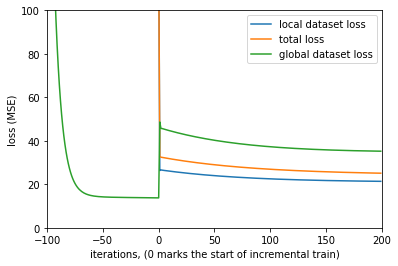

In [84]:
plt.plot(ll, label='local dataset loss')
plt.plot(tl, label='total loss')
plt.plot(np.arange(-100, 200), loss1 + gl, label='global dataset loss')
plt.xlabel("iterations, (0 marks the start of incremental train)")
plt.ylabel("loss (MSE)")
plt.ylim(0, 100)
plt.xlim(-100, 200)
plt.legend()

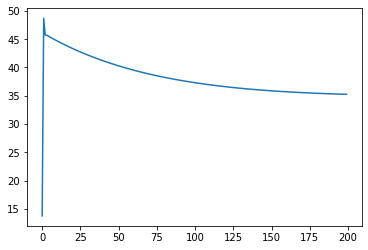

In [85]:
plt.plot(gl)


# The N-D Case

In [86]:
# Initial data
x_dims = 28*28

import tensorflow_datasets as tfds

def load_dataset(
    split: str,
):
  ds = tfds.load("mnist:3.*.*", split=split)

  return iter(tfds.as_numpy(ds))

# Make datasets.
train_data = load_dataset("train",)
test_eval = load_dataset("test", )

imgs = []
lbs = []
for d in train_data:
  imgs.append(d['image'].flatten().astype(jnp.float32) / 255.)
  lbs.append(d['label'])
    
randix = np.random.shuffle(np.arange(len(imgs)))

train_full_data = np.stack(imgs)[randix]
train_full_label = np.stack(lbs)[randix]

imgs = []
lbs = []
for d in test_eval:
  imgs.append(d['image'].flatten().astype(jnp.float32) / 255.)
  lbs.append(d['label'])
    

test_full_data = np.stack(imgs)
test_full_label = np.stack(lbs)


In [87]:
def accuracy(W, b, X, y):
    y_hat = X@W + b
    y_hat = jnp.argmax(y_hat, axis=1)
    correct = y == y_hat
    return float(sum(correct) / len(correct))

In [88]:
def ce(y_hat, y):
  labels = jax.nn.one_hot(y, 10)
  softmax_xent = -jnp.sum(labels * jax.nn.log_softmax(y_hat))
  softmax_xent /= labels.shape[0]
  return softmax_xent

@jit
def cost_function(X, w, b, y):
    """Cost function for a linear regression. A forward pass of our model.

    Args:
        X: a features matrix.
        w: weights (a column vector).
        b: a bias.
        y: a target vector.

    Returns:
        scalar: a cost of this solution.    
    """
    y_hat = X.dot(w) + b # Predict values.
    return ce(y_hat, y)# Return cost.

In [89]:
idx_global = (train_full_label >= 0) & (train_full_label <= 7 )
idx_local = (train_full_label >= 8) & (train_full_label <= 9 )

X_1, y_1 = train_full_data[idx_global], train_full_label[idx_global]
X_2, y_2 = train_full_data[idx_local], train_full_label[idx_local]

idx = np.random.choice(np.arange(len(X_1)), int(len(X_1) * 0.05))
X_s = np.concatenate([X_1[idx], X_2])
y_s = np.concatenate([y_1[idx], y_2])


In [90]:
idx_global = (test_full_label >= 0) & (test_full_label <= 7 )
idx_local = (test_full_label>= 8) & (test_full_label <= 9 )
X_test1, y_test1 = test_full_data[idx_global], test_full_label[idx_global]
X_test2, y_test2 = test_full_data[idx_local], test_full_label[idx_local]

In [91]:
X_2.dtype, y_2.dtype, len(X_1), len(X_2), len(X_s), min(y_1), max(y_1), min(y_2), max(y_2),

(dtype('float32'), dtype('int64'), 48200, 11800, 14210, 0, 7, 8, 9)

In [92]:
# from jax import vmap
# %matplotlib inline

# W_a, b_a, h_a = get_analytical_solution(X_1, y_1)
# W_a_l, b_a_l, h_a_l = get_analytical_solution(X_2, y_2)
# W_a_i, b_a_i, h_a_i = get_analytical_solution(X_s, y_s)

# def get_eigen(h):
#     eigens = np.linalg.eig(h)[0]
#     #eigens /= max(eigens)
#     #eigens = ["{:.2f}".format(float(i)) for i in eigens]
#     return eigens#" ".join(eigens)

# fig, ax = plt.subplots(3)

# #print("Orignal optimal\n", W_a, b_a)
# ax[0].hist(get_eigen(h_a).flatten())
# ax[0].set_title("Global Eigenvalues:")

# ax[1].hist(get_eigen(h_a_l).flatten())
# ax[1].set_title("Local Eigenvalues:",)

# ax[2].hist(get_eigen(h_a_i).flatten())
# ax[2].set_title("Mixed Eigenvalues:")

# for a in ax:
#     a.set_yscale('log')

# fig.tight_layout()

In [93]:
from jax import jvp

def hvp(J, w, v):
    return jvp(grad(J), (w,), (v,))[1]

def rayleigh_quotient(J, w, v):
    Hv = hvp(J, w, v)
    return (Hv @ v) / (v @ v)

def pack_params(W, b):
    vec = np.concatenate([W.flatten(), b.flatten()])
    return vec

def unpack_params(vec):
    
    W = vec[:28*28*10]
    b = vec[28*28*10:]
    W = W.reshape(28*28, 10)
    b = b.reshape(10)
    return W, b
                  
    
def cost_function_global(ws):
    w, b = unpack_params(ws)
    o = cost_function(X_1, w, b, y_1)
    return o

def cost_function_local(ws):
    w, b = unpack_params(ws)
    o = cost_function(X_2, w, b, y_2)
    return o

def cost_function_mixed(ws):
    w, b = unpack_params(ws)
    o = cost_function(X_s, w, b, y_s)
    return o



In [94]:
# params
W = jnp.zeros((x_dims, 10))
b = jnp.zeros(10)
loss1, accs, W_g, b_g, wg_traj, bg_traj = train_mnist(X_1, y_1, W, b, X_test1, y_test1, lr=0.3, epochs=100)



100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


Initial loss: 2.3025850929940463, final loss 0.2976458638984158
Final Accuracy: 0.9305226393912935
[ 0.00544438 -0.0091737   0.00880221  0.00652908 -0.00103526  0.00815313
  0.00273649  0.00173817  0.          0.        ]


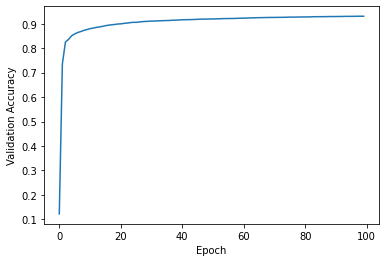

In [95]:
#plt.plot(loss1)
plt.plot(accs, label="MNIST GD validation accuracy")
plt.xlabel("Epoch")
plt.ylabel("Validation Accuracy")
print("Initial loss: {}, final loss {}".format(loss1[0], loss1[-1]))

acc = accs[-1]
print("Final Accuracy:", acc)
W_g_new = W_g.at[:, 8:].set(0)
b_g_new = b_g.at[8:].set(0)
print(W_g_new.T.mean(axis=1))

In [96]:
%matplotlib inline
gl, ll, tl, W, b, wl_traj, bl_traj = \
    train_incremental_mnist(X_1, y_1, X_2, y_2, W_g_new, b_g_new, X_test1, y_test1, X_test2, y_test2,test_full_data, test_full_label,
                      X_m=X_s, y_m=y_s, 
                      lr=0.1, sample=0.0, epochs=100,)


100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


In [97]:
print("Initial loss: {}, final loss {}".format(tl[0][0], tl[-1][0]))

acc_g = gl[-1][1]
print("Global Accuracy:", acc_g)
acc_l = ll[-1][1]
print("Local Accuracy:", acc_l)
acc_mixed = tl[-1][1]
print("Mixed Accuracy:", acc_mixed)


Initial loss: 3.905045040993968, final loss 0.308482112811589
Global Accuracy: 0.6590994137457902
Local Accuracy: 0.9631870902672718
Mixed Accuracy: 0.7194


(0.0, 3.0)

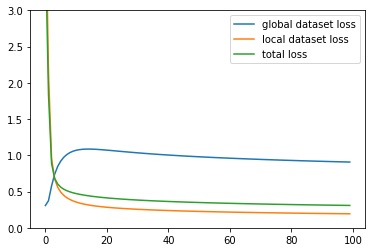

In [98]:
plt.plot(list(map(lambda x:x[0], gl)), label='global dataset loss')
plt.plot(list(map(lambda x:x[0], ll)), label='local dataset loss')
plt.plot(list(map(lambda x:x[0], tl)), label='total loss')
plt.legend()
plt.ylim(0, 3)

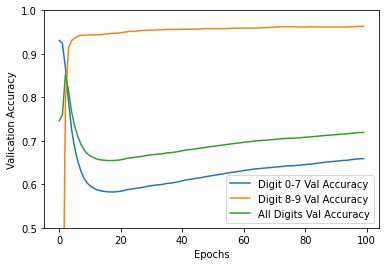

In [99]:
plt.plot(list(map(lambda x:x[1], gl)), label='Digit 0-7 Val Accuracy')
plt.plot(list(map(lambda x:x[1], ll)), label='Digit 8-9 Val Accuracy')
plt.plot(list(map(lambda x:x[1], tl)), label='All Digits Val Accuracy')
plt.xlabel("Epochs")
plt.ylim(0.5, 1)
plt.ylabel("Valication Accuracy")
plt.legend()

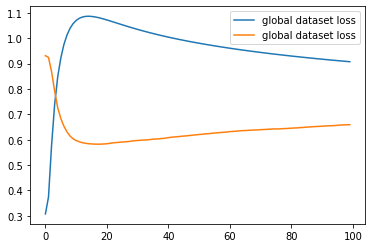

In [100]:
plt.plot(gl, label='global dataset loss')
plt.legend()

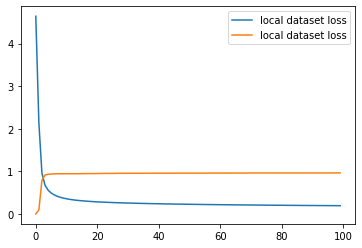

In [101]:
plt.plot(ll, label='local dataset loss')
plt.legend()

In [156]:
from sklearn.preprocessing import normalize

k = jax.random.PRNGKey(3240)
rand_vec = jax.random.normal(k, (1000, 28*28*10 + 10))
norm_vec = normalize(rand_vec, axis=1, norm='l2') 

def get_direction(cost, w, b):
    ws = pack_params(w, b)
    hv = vmap(hvp, (None, None, 0))(cost, ws, norm_vec)
    hv = hv.sum(axis=0)
    hv = hv.reshape(28*28 + 1, 10)
    hv = hv.T
    return hv.flatten() 


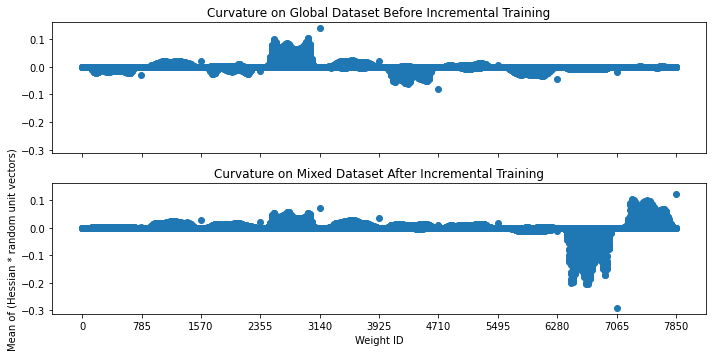

In [157]:
curv_global = get_direction(cost_function_global, W_g_new, b_g_new)
curve_incre = get_direction(cost_function_mixed, W, b)
fig, ax = plt.subplots(2,sharex='all', sharey='all', figsize=(10,5))
scatter_x = np.arange(10 * (x_dims  + 1))

ax[0].scatter(scatter_x, curv_global.flatten())
ax[1].scatter(scatter_x, curve_incre.flatten())

ax[0].set_title("Curvature on Global Dataset Before Incremental Training")
ax[1].set_title("Curvature on Mixed Dataset After Incremental Training")

for a in ax[1:]:
    a.set_xticks(list(range(0, len(curv_global)+1, len(curv_global)//10)))
    a.set_xlabel("Weight ID")
    a.set_ylabel("Mean of (Hessian * random unit vectors)")

fig.tight_layout()

In [158]:
gl, ll, tl, W, b, wl_traj, bl_traj, rgs, rls = \
    train_incremental_mnist_relay(X_1, y_1, X_2, y_2, W_g_new, b_g_new, X_test1, y_test1, X_test2, y_test2,test_full_data, test_full_label,
                      X_m=X_s, y_m=y_s, 
                      lr=0.1, sample=0.0, epochs=100,)

100%|██████████| 100/100 [00:51<00:00,  1.95it/s]


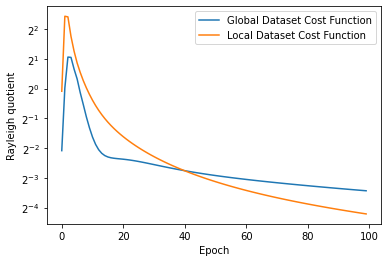

In [159]:
plt.plot(rgs, label='Global Dataset Cost Function')
plt.plot(rls, label='Local Dataset Cost Function')
plt.yscale('log', base=2)
plt.xlabel('Epoch')
plt.ylabel('Rayleigh quotient')
plt.legend()